In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
import string
import re

from sklearn.feature_extraction.text import CountVectorizer

import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

import joblib
from funcsigs import signature

In [11]:
output_dir = "./results/baseline_classifiers/"
def vote_score(df, score, output_dir, model_name):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
#     print("df initial shape: ", df.shape)
    # score
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max) + df_sort.groupby(['ID'])['pred_score'].agg(sum) / 2) / (
                1 + df_sort.groupby(['ID'])['pred_score'].agg(len) / 2)

    x = df_sort.groupby(['ID'])['Label'].agg(np.min).values
#     print("x is: ", x)
    df_out = pd.DataFrame({'logits': temp.values, 'Label': x})
    
    
    pred_labels =  np.asarray([1 if i else 0 for i in (temp >= 0.5)])
    true_labels = df_out["Label"]
    
    
    print(classification_report(true_labels, pred_labels))
#     print("df_out shape is: ", df_out.shape)
#     print(df_out.head())

    fpr, tpr, thresholds = roc_curve(x, temp.values)
    auc_score = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Test (area = {:.3f})'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    
    plt.savefig(f'{output_dir}auroc_{model_name}_discharge.png')
    plt.show()
    
#     string = 'auroc_clinicalbert_' + args.readmission_mode + '.png'
#     plt.savefig(os.path.join(args.output_dir, string))

    return fpr, tpr, df_out


def pr_curve_plot(y, y_score, output_dir, model_name):
    precision, recall, _ = precision_recall_curve(y, y_score)
    area = auc(recall, precision)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.figure(2)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(
        area))
    
    plt.savefig(f'{output_dir}auprc_{model_name}_discharge.png')
    plt.show()
#     string = 'auprc_clinicalbert_' + args.readmission_mode + '.png'

#     plt.savefig(os.path.join(args.output_dir, string))


def vote_pr_curve(df, score, output_dir, model_name):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    # score
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max) + df_sort.groupby(['ID'])['pred_score'].agg(sum) / 2) / (
                1 + df_sort.groupby(['ID'])['pred_score'].agg(len) / 2)
    print("temp shapes n ting")
    print(temp.shape)
    print(temp.head())
    y = df_sort.groupby(['ID'])['Label'].agg(np.min).values

    precision, recall, thres = precision_recall_curve(y, temp)
    pr_thres = pd.DataFrame(data=list(zip(precision, recall, thres)), columns=['prec', 'recall', 'thres'])
    vote_df = pd.DataFrame(data=list(zip(temp, y)), columns=['score', 'label'])

    pr_curve_plot(y, temp, output_dir, model_name)
    
    temp = pr_thres[pr_thres.prec > 0.799999].reset_index()
    print(f"temp after threshold applied: {temp}")

    rp80 = 0
    if temp.size == 0:
        print('Test Sample too small or RP80=0')
    else:
        rp80 = temp.iloc[0].recall
        print('Recall at Precision of 80 is {}', rp80)

    return rp80

In [27]:
# read in all the logits for each model

# clinBERT_org_df = pd.read_csv("./results/result_newest_3layerClinicalBERTPretrained_discharge_210421_v2/logits_clinicalbert_discharge_chunks.csv", index_col=0)
# clinBERT_org_proba = clinBERT_org_df.logits
# clinBERT_new_df = pd.read_csv("./results/results_updated_BioClinicalBERTpretrained_discharge_220421_v2/logits_preds_truths.csv", index_col=0)
# clinBERT_new_proba = clinBERT_new_df.logits
# spg_df = pd.read_csv("../OxLegalReasoning/artifacts/RCNN_IB_GAN_be_mimic3_org_embs2021-05-12/batch_all_chosen_words.csv", index_col=0)
# spg_df.reset_index(inplace=True)
# spg_proba = spg_df.proba


# lr_df = pd.read_csv("./results/baseline_classifiers/LogReg_proba.csv", index_col=0)
# lr_proba = lr_df.proba

# rf_df = pd.read_csv("./results/baseline_classifiers/RF_proba.csv", index_col=0)
# rf_proba = rf_df.proba

# xgb_df = pd.read_csv("./results/baseline_classifiers/XGB_proba.csv", index_col=0)
# xgb_proba = xgb_df.proba

lstm_vanilla_df = pd.read_csv("../OxLegalReasoning/results/LSTM_Vanilla_newembeddings/lstm_vanilla_eval_probs.csv", index_col = 0)
lstm_vanilla_probs = lstm_vanilla_df.proba


lstm_vanilla_org_df = pd.read_csv("../OxLegalReasoning/results/LSTM_Vanilla_orgembedding/lstm_vanilla_eval_probs.csv")
lstm_vanilla_org_probs = lstm_vanilla_org_df.proba

lstm_vanilla_strict_df = pd.read_csv("../OxLegalReasoning/results/LSTM_Vanilla_strict/lstm_vanilla_eval_probs.csv")
lstm_vanilla_strict_probs = lstm_vanilla_strict_df.proba

In [25]:
# lstm_vanilla_org_df

In [6]:
lstm_vanilla_probs.shape

(3063,)

In [18]:
lstm_vanilla_org_probs.shape

(3063,)

In [1]:
print(clinBERT_org_proba.shape)
print(clinBERT_new_proba.shape)
print(spg_proba.shape)
print(lr_proba.shape)
print(rf_proba.shape)
print(xgb_proba.shape)

NameError: name 'clinBERT_org_proba' is not defined

In [7]:
# get test data labels

test_data = pd.read_csv("./data/discharge/test.csv",index_col = 0)

test_data.reset_index(inplace=True)
len(test_data.ID.unique())

584

working on clinicalBERT
working on clinicalBioBert
working on SPG InfoCal
working on Logistic regression
working on Random forest


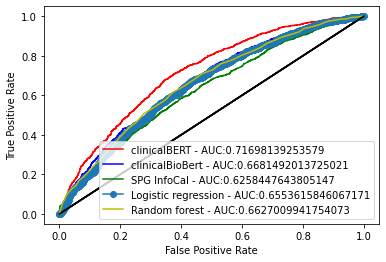

In [16]:
# get figure with all on
model_names = ["clinicalBERT", "clinicalBioBert","SPG InfoCal","Logistic regression", "Random forest", "XGBoost"]
model_probabilities = [clinBERT_org_proba, clinBERT_new_proba, spg_proba,lr_proba,
                      rf_proba,xgb_proba]
colours = ["r-","b-","g-","o-","y-"]


for name,probas, c in zip(model_names,model_probabilities, colours):
    print(f"working on {name}")   
    

    fpr_test, tpr_test, thresholds_test = roc_curve(test_y, probas)
    thresh = 0.5

    auc_test = roc_auc_score(test_y, probas)
 
    plt.plot(fpr_test, tpr_test,c, label = f"{name} - AUC:{auc_test}")
    
    plt.plot([0,1],[0,1],'-k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
plt.show()
    
    
    


In [26]:
clinBERT_org_proba

0       0.001226
1       0.984718
2       0.000028
3       0.996788
4       0.999979
          ...   
3058    0.999972
3059    0.999700
3060    0.999896
3061    0.514594
3062    0.000017
Name: logits, Length: 3063, dtype: float64

In [43]:
clinBERT_new_proba

0       0.010779
1       0.270687
2      -0.114882
3       0.214097
4       1.243355
          ...   
3058   -0.589479
3059    0.743576
3060   -0.214959
3061   -0.297657
3062    0.244652
Name: logits, Length: 3063, dtype: float64

In [29]:
spg_proba

0       0.446407
1       0.424603
2       0.380575
3       0.453334
4       0.599406
          ...   
3058    0.426431
3059    0.349250
3060    0.399647
3061    0.469592
3062    0.432333
Name: proba, Length: 3063, dtype: float64

(584,)
x is:  [1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 

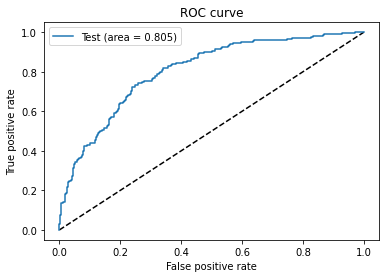

AttributeError: 'DataFrame' object has no attribute 'ID'

In [48]:
fpr, tpr, df_out = vote_score(test_data, clinBERT_org_proba, output_dir = output_dir, model_name=name)
# df_out.ID.unique()

# TODO - adapt the vote score function to get the f1-scores etc based on the updated definition of readmission. 

              precision    recall  f1-score   support

         0.0       0.65      0.56      0.60       294
         1.0       0.61      0.69      0.65       290

    accuracy                           0.63       584
   macro avg       0.63      0.63      0.63       584
weighted avg       0.63      0.63      0.63       584



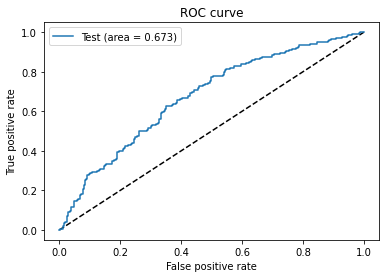

temp shapes n ting
(584,)
ID
100133.0    0.638883
100143.0    0.513126
100294.0    0.273498
100380.0    0.528443
100485.0    0.413129
Name: pred_score, dtype: float64


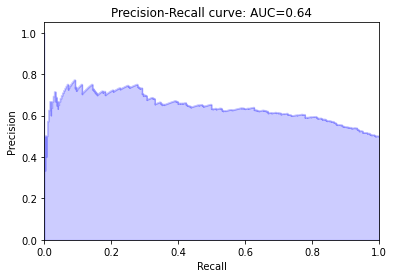

temp after threshold applied: Empty DataFrame
Columns: [index, prec, recall, thres]
Index: []
Test Sample too small or RP80=0


0

In [29]:
vote_score(test_data, lstm_vanilla_probs, output_dir = output_dir, model_name="lstm_vanilla")
vote_pr_curve(test_data, lstm_vanilla_probs, output_dir = output_dir, model_name="lstm_vanilla")

              precision    recall  f1-score   support

         0.0       0.64      0.46      0.53       294
         1.0       0.57      0.74      0.65       290

    accuracy                           0.60       584
   macro avg       0.61      0.60      0.59       584
weighted avg       0.61      0.60      0.59       584



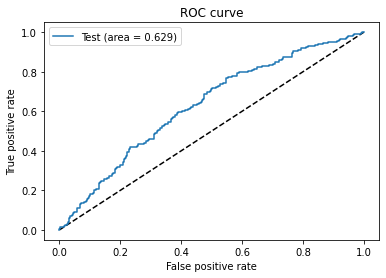

temp shapes n ting
(584,)
ID
100133.0    0.528766
100143.0    0.526845
100294.0    0.411424
100380.0    0.507464
100485.0    0.471339
Name: pred_score, dtype: float64


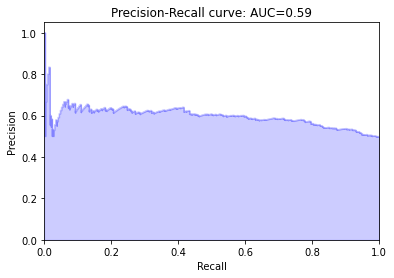

temp after threshold applied:    index      prec    recall     thres
0    576  0.833333  0.017241  0.609266
1    577  0.800000  0.013793  0.611639
2    581  1.000000  0.003448  0.626550
Recall at Precision of 80 is {} 0.017241379310344827


0.017241379310344827

In [26]:
vote_score(test_data, lstm_vanilla_org_probs, output_dir = output_dir, model_name="lstm_vanilla")
vote_pr_curve(test_data, lstm_vanilla_org_probs, output_dir = output_dir, model_name="lstm_vanilla")

              precision    recall  f1-score   support

         0.0       0.67      0.47      0.56       294
         1.0       0.59      0.77      0.67       290

    accuracy                           0.62       584
   macro avg       0.63      0.62      0.61       584
weighted avg       0.63      0.62      0.61       584



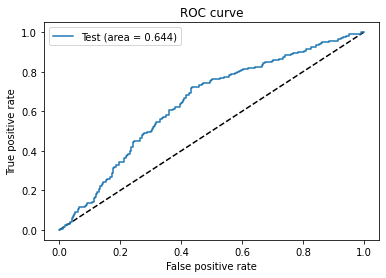

temp shapes n ting
(584,)
ID
100133.0    0.521618
100143.0    0.579821
100294.0    0.310901
100380.0    0.542686
100485.0    0.519013
Name: pred_score, dtype: float64


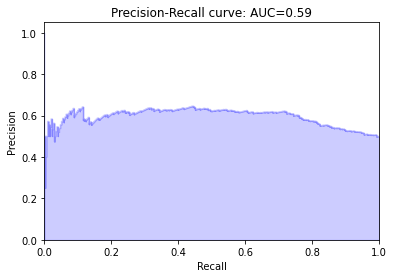

temp after threshold applied: Empty DataFrame
Columns: [index, prec, recall, thres]
Index: []
Test Sample too small or RP80=0


0

In [28]:
# lstm_vanilla_strict_probs
vote_score(test_data, lstm_vanilla_strict_probs, output_dir = output_dir, model_name="lstm_vanilla")
vote_pr_curve(test_data, lstm_vanilla_strict_probs, output_dir = output_dir, model_name="lstm_vanilla")


working on clinicalBERT
              precision    recall  f1-score   support

         0.0       0.80      0.57      0.66       294
         1.0       0.66      0.86      0.75       290

    accuracy                           0.71       584
   macro avg       0.73      0.71      0.70       584
weighted avg       0.73      0.71      0.70       584



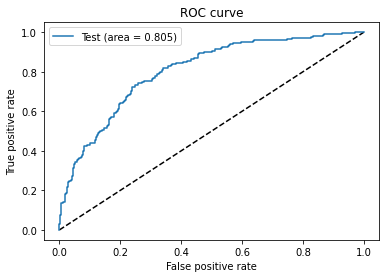

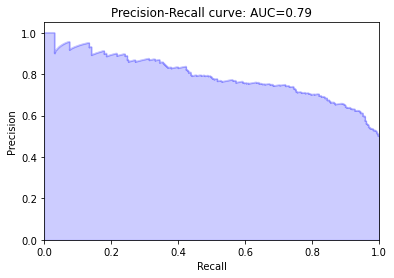

Recall at Precision of 80 is {} 0.4379310344827586
working on clinicalBioBert
              precision    recall  f1-score   support

         0.0       0.78      0.45      0.57       294
         1.0       0.61      0.87      0.71       290

    accuracy                           0.66       584
   macro avg       0.69      0.66      0.64       584
weighted avg       0.69      0.66      0.64       584



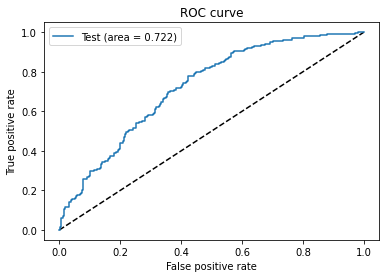

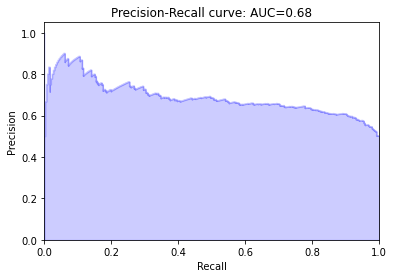

Recall at Precision of 80 is {} 0.15172413793103448
working on SPG InfoCal
              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66       294
         1.0       0.65      0.59      0.62       290

    accuracy                           0.64       584
   macro avg       0.64      0.64      0.64       584
weighted avg       0.64      0.64      0.64       584



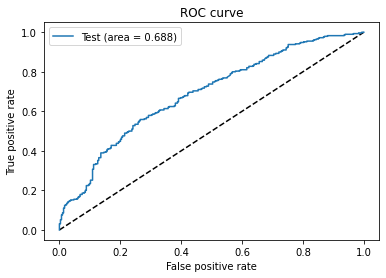

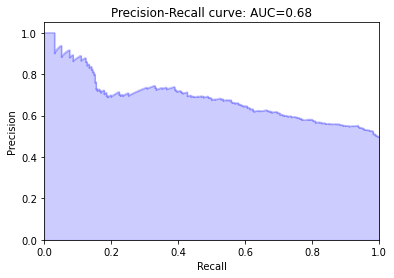

Recall at Precision of 80 is {} 0.15172413793103448
working on Logistic regression
              precision    recall  f1-score   support

         0.0       0.64      0.64      0.64       294
         1.0       0.63      0.63      0.63       290

    accuracy                           0.64       584
   macro avg       0.64      0.64      0.64       584
weighted avg       0.64      0.64      0.64       584



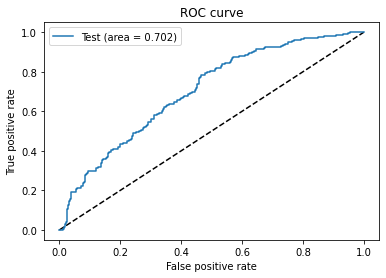

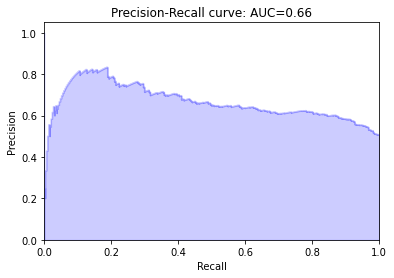

Recall at Precision of 80 is {} 0.1896551724137931
working on Random forest
              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63       294
         1.0       0.63      0.69      0.66       290

    accuracy                           0.64       584
   macro avg       0.64      0.64      0.64       584
weighted avg       0.64      0.64      0.64       584



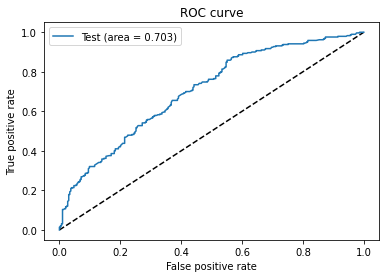

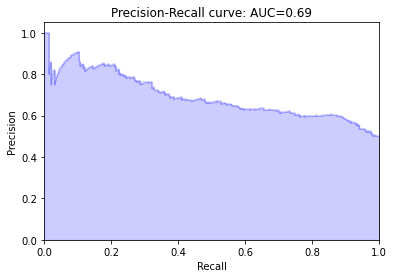

Recall at Precision of 80 is {} 0.23448275862068965
working on XGBoost
              precision    recall  f1-score   support

         0.0       0.65      0.60      0.62       294
         1.0       0.62      0.67      0.65       290

    accuracy                           0.64       584
   macro avg       0.64      0.64      0.63       584
weighted avg       0.64      0.64      0.63       584



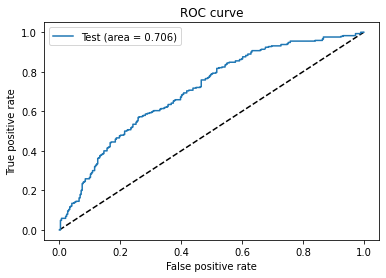

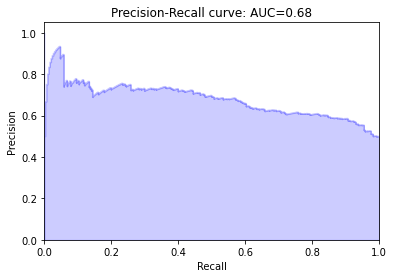

Recall at Precision of 80 is {} 0.05862068965517241


In [55]:
# get figure with all on
model_names = ["clinicalBERT", "clinicalBioBert","SPG InfoCal","Logistic regression", "Random forest", "XGBoost"]
model_probabilities = [clinBERT_org_proba, clinBERT_new_proba, spg_proba,lr_proba,
                      rf_proba,xgb_proba]
colours = ["r-","b-","g-","o-","y-","b-"]


for name,probas, c in zip(model_names,model_probabilities, colours):
    print(f"working on {name}")  

    vote_score(test_data, probas, output_dir = output_dir, model_name=name)
    vote_pr_curve(test_data, probas, output_dir = output_dir, model_name=name)
    


    